In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits, assess_goodnes_of_cross_match, rayleigh_plot
import pandas as pd
import numpy as np
import seaborn as sns
import nway_python_api as nway
set_mpl()
%matplotlib inline

matplotlib settings set


matplotlib settings set
This is NWAY Python API
nwaylib file /Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py
matplotlib settings set


In [3]:
desi_pandas_ph =  pd.read_pickle(data_path+'desi_lh.gz_pkl', compression = 'gzip')
desi_pandas_ph.columns = ['desi_'+x for x in desi_pandas_ph.columns]
desi_pandas_ph.rename(columns={'desi_desi_id':'nway_desi_id'}, inplace=True)


erosita_orig_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')
#set EROSITA as an index
erosita_orig_df['EROSITA'] = erosita_orig_df.index

In [4]:
ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits') #this catalog is used for nway cross-matching
ero_ctps_pandas = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
ero_pandas = ero_pandas.merge(ero_ctps_pandas, on='ID', how='left')

nway_res = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway.pkl')
nway_res_dist_only = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway_distance_only.pkl')


In [5]:
ero_ctps_pandas[ero_ctps_pandas.desi_id_true_ctp!=b'hostless']

,ID,desi_id_true_ctp
0,b'SRGe J103105.9+573747',b'9011_610714_1440'
1,b'SRGe J103118.8+574434',b'9011_610714_1908'
2,b'SRGe J103123.8+574309',b'9011_610714_2092'
3,b'SRGe J103130.8+573932',b'9011_610714_2412'
4,b'SRGe J103137.0+573159',b'9011_609939_1093'
...,...,...
782,b'SRGe J110633.0+590313',b'9011_614527_1198'
783,b'SRGe J110645.0+590331',b'9011_614527_1596'
784,b'SRGe J110648.4+585514',b'9011_614527_1704'
785,b'SRGe J110721.2+585635',b'9011_614527_2647'


In [6]:
def get_flag_num(x, flag):
    try:
        return x.value_counts()[flag]
    except:
        return 0

nway_res['n_match_flag_0'] = nway_res.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 0))
nway_res['n_match_flag_2'] = nway_res.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 2))
tmp = nway_res.groupby('EROSITA')['Separation_EROSITA_DESI'].transform(lambda x: min(x))
nway_res['is_closest'] = tmp == nway_res['Separation_EROSITA_DESI']
nway_res['is_within_pos_r98'] = nway_res['Separation_EROSITA_DESI'] < 2.79*nway_res['pos_err'] #2.79 if the coeff to transform pos_sigma2d (0.39 prob) into pos_r98 (0.98 prob) via  [0.98 = 1 - exp(-r^2/2) solve for r]. Assuming pos_err is the standard deviation of the position error (sigma 2d, 39% probability)
#nway_res['closest_is_not_PSF'] = nway_res['is_closest'] & (nway_res['match_flag']!=2)



nway_res_dist_only['n_match_flag_0'] = nway_res_dist_only.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 0))
nway_res_dist_only['n_match_flag_2'] = nway_res_dist_only.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 2))
tmp = nway_res_dist_only.groupby('EROSITA')['Separation_EROSITA_DESI'].transform(lambda x: min(x))
nway_res_dist_only['is_closest'] = tmp == nway_res_dist_only['Separation_EROSITA_DESI']
nway_res_dist_only['is_within_pos_r98'] = nway_res_dist_only['Separation_EROSITA_DESI'] < 2.79*nway_res_dist_only['pos_err'] 


In [8]:
print(nway_res.query('match_flag == 1').groupby('is_closest')['is_within_pos_r98'].value_counts())
print(nway_res_dist_only.query('match_flag == 1').groupby('is_closest')['is_within_pos_r98'].value_counts())

is_closest  is_within_pos_r98
False       True                 1347
            False                 237
True        True                 7034
            False                 600
Name: is_within_pos_r98, dtype: int64
is_closest  is_within_pos_r98
True        True                 8509
            False                 709
Name: is_within_pos_r98, dtype: int64


# Completeness/purity analysis

In [9]:
print(nway_res.query('desi_id == desi_id_true_ctp & is_within_pos_r98 == 1').is_closest.value_counts())


True     567
False     91
Name: is_closest, dtype: int64


In [10]:
print('not hostless validation only')
print('correct match + within r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id==desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 1').is_closest.value_counts())
print('incorrect  match + within r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id!=desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 1').is_closest.value_counts())
print('correct match + outside r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id==desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 0').is_closest.value_counts())
print('incorrect match + outside r98: is_closest or not')
print(nway_res.query('desi_id_true_ctp!="hostless" & match_flag==1 & desi_id!=desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 0').is_closest.value_counts())

not hostless validation only
correct match + within r98: is_closest or not
True     562
False     64
Name: is_closest, dtype: int64
incorrect  match + within r98: is_closest or not
True     59
False    11
Name: is_closest, dtype: int64
correct match + outside r98: is_closest or not
True     10
False     5
Name: is_closest, dtype: int64
incorrect match + outside r98: is_closest or not
True     23
False     6
Name: is_closest, dtype: int64


matplotlib settings set
 NOT HOSTLESS 
assigned NOT HOSTLESS: 650
assigned NOT HOSTLESS with correct match: 615
total: 686
purity [assigned NOT HOSTLESS correctly / all NOT HOSTLESS]: 0.9461538461538461
completeness [all NOT HOSTLESS / total NOT HOSTLESS]: 0.9475218658892128
 HOSTLESS 
assigned HOSTLESS: 39
assigned HOSTLESS correctly: 39
total HOSTLESS: 54
purity [assigned HOSTLESS correctly / all assigned HOSTLESS]: 1.0
completeness [all HOSTLESS assigned / total HOSTLESS]: 0.7222222222222222
 NOT HOSTLESS 
assigned NOT HOSTLESS: 585
assigned NOT HOSTLESS with correct match: 500
total: 686
purity [assigned NOT HOSTLESS correctly / all NOT HOSTLESS]: 0.8547008547008547
completeness [all NOT HOSTLESS / total NOT HOSTLESS]: 0.8527696793002916
 HOSTLESS 
assigned HOSTLESS: 43
assigned HOSTLESS correctly: 43
total HOSTLESS: 54
purity [assigned HOSTLESS correctly / all assigned HOSTLESS]: 1.0
completeness [all HOSTLESS assigned / total HOSTLESS]: 0.7962962962962963
 NOT HOSTLESS 
assigned 

Text(0.5, 0.98, 'XMM/CHANDRA Lockman Hole validation catalog')

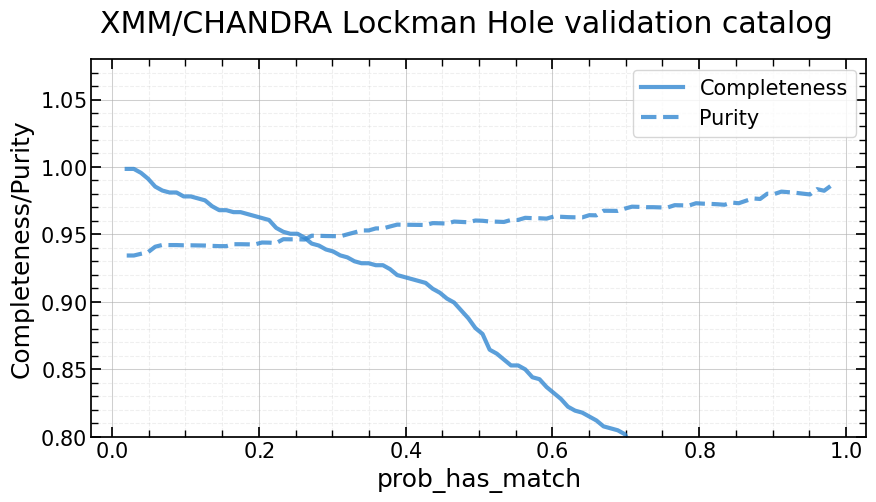

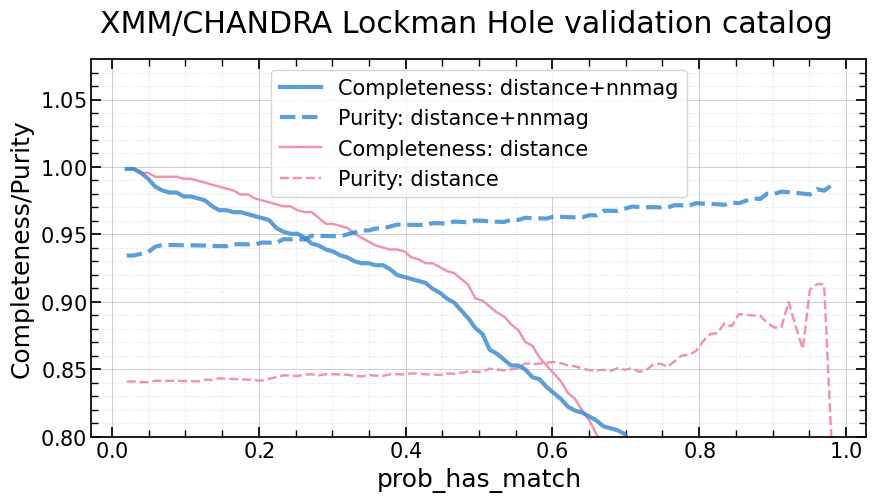

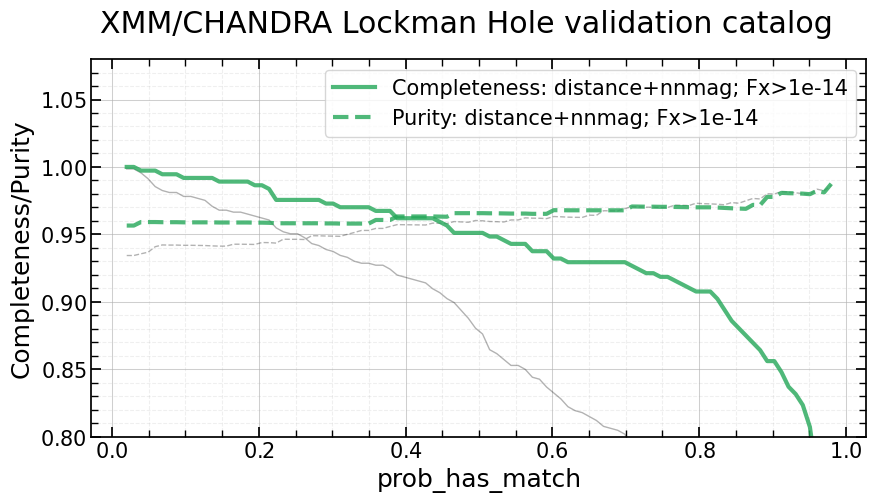

In [11]:
set_mpl()
cutoffs_nnmag, completeness_nnmag, purity_nnmag , _, _, _= assess_goodnes_of_cross_match(nway_res, plot_res=False)

cutoffs_dist_only, completeness_dist_only, purity_dist_only , _, _, _= assess_goodnes_of_cross_match(nway_res_dist_only, plot_res=False)



plt.figure(figsize=(10,5))

plt.plot(cutoffs_nnmag, completeness_nnmag, 'C0-', lw = 3, alpha = 0.8, label=f'Completeness')
plt.plot(cutoffs_nnmag, purity_nnmag, 'C0--', lw = 3,  alpha = 0.8, label=f'Purity')

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')


plt.figure(figsize=(10,5))

plt.plot(cutoffs_nnmag, completeness_nnmag, 'C0-', lw = 3, alpha = 0.8, label=f'Completeness: distance+nnmag')
plt.plot(cutoffs_nnmag, purity_nnmag, 'C0--', lw = 3,  alpha = 0.8, label=f'Purity: distance+nnmag')

plt.plot(cutoffs_dist_only, completeness_dist_only, 'C1-', alpha = 0.5, label=f'Completeness: distance', zorder = -1)
plt.plot(cutoffs_dist_only, purity_dist_only, 'C1--', alpha = 0.5, label=f'Purity: distance', zorder = -1)

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')



plt.figure(figsize=(10,5))


#cutoff_intersection_nnmag_bright, completeness_intersection_nnmag_bright,  cutoffs_nnmag_bright, completeness_nnmag_bright, purity_nnmag_bright = assess_goodnes_nway_cross_match(nway_res[nway_res.ML_FLUX_0>1e-14], plot_res=False)

cutoffs_nnmag_bright, completeness_nnmag_bright, purity_nnmag_bright , _, _, _= assess_goodnes_of_cross_match(nway_res.query('ML_FLUX_0>1e-14'), plot_res=False)



plt.plot(cutoffs_nnmag, completeness_nnmag, 'k-', lw = 1, alpha = 0.3, label=f'_Completeness: distance+nnmag')
plt.plot(cutoffs_nnmag, purity_nnmag, 'k--', lw = 1,  alpha = 0.3, label=f'_Purity: distance+nnmag')


plt.plot(cutoffs_nnmag_bright, completeness_nnmag_bright, 'C2-', lw = 3, alpha = 0.8, label=f'Completeness: distance+nnmag; Fx>1e-14')
plt.plot(cutoffs_nnmag_bright, purity_nnmag_bright, 'C2--', lw = 3,  alpha = 0.8, label=f'Purity: distance+nnmag; Fx>1e-14')

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')


# Plot distribution of nnmags for good matches with validation catalog

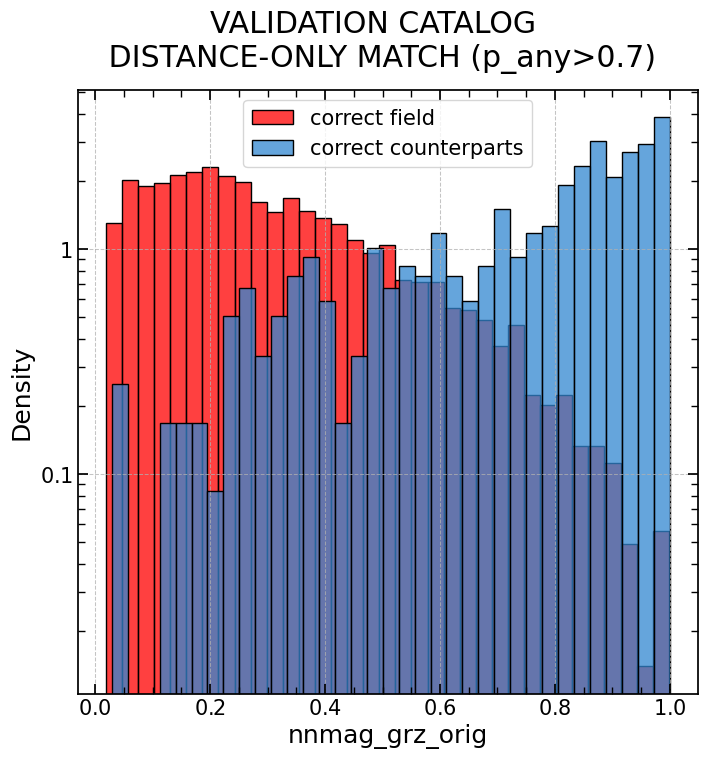

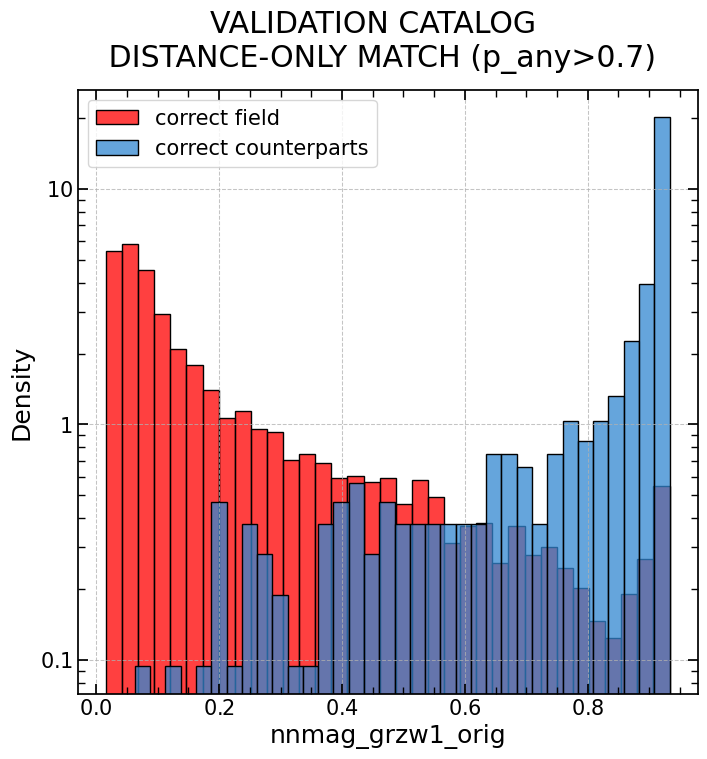

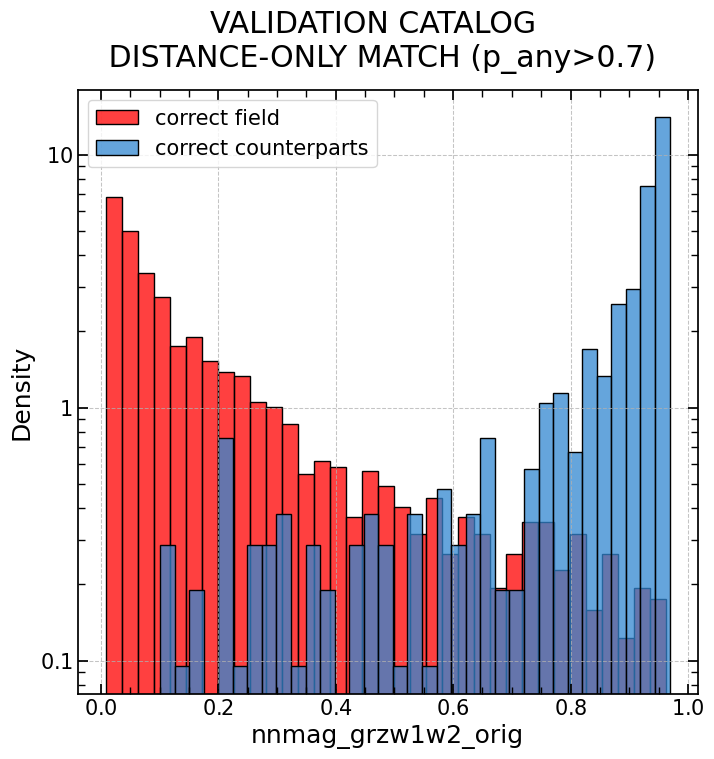

In [14]:
for prior_type in ['grz_orig', 'grzw1_orig', 'grzw1w2_orig']:
    prob_cutoff = 0.7
    plt.figure()
    sns.histplot(nway_res_dist_only.query(f"prob_has_match>@prob_cutoff & match_flag==0 & nnmag_{prior_type}!=-99. & ~desi_id_true_ctp.isnull()")['nnmag_'+prior_type], stat = 'density', color = 'r', bins = 35, label = 'correct field')
    sns.histplot(nway_res_dist_only.query(f"prob_has_match>@prob_cutoff & match_flag==1 & nnmag_{prior_type}!=-99. & desi_id==desi_id_true_ctp")['nnmag_'+prior_type], stat = 'density', bins = 35, label = 'correct counterparts')
    plt.suptitle(f'VALIDATION CATALOG \n DISTANCE-ONLY MATCH (p_any>{prob_cutoff})')
    plt.yscale('log')
    plt.legend()

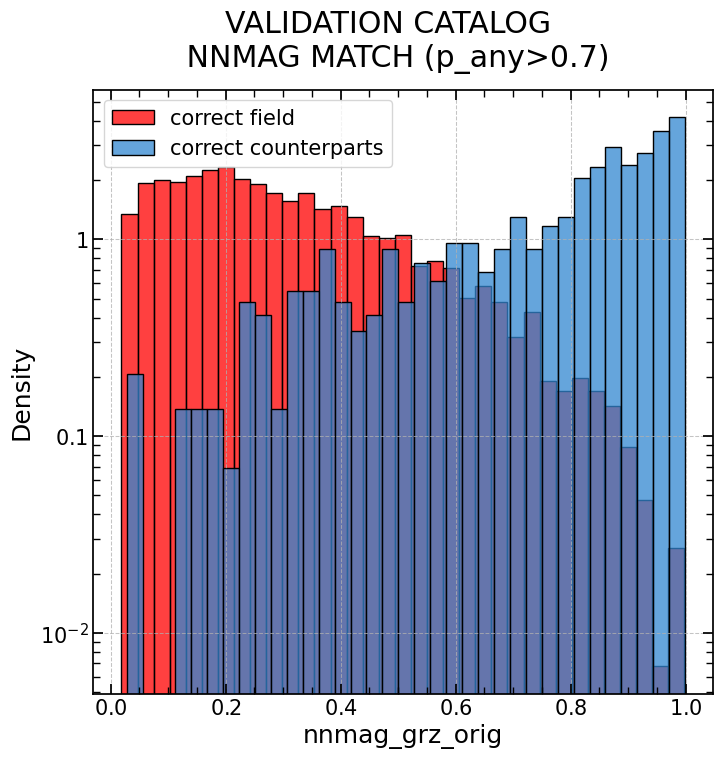

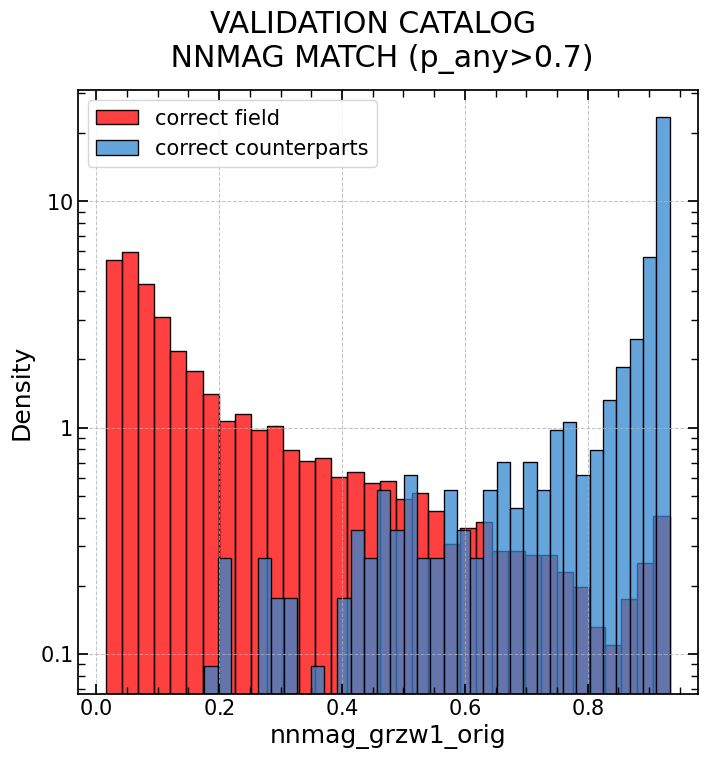

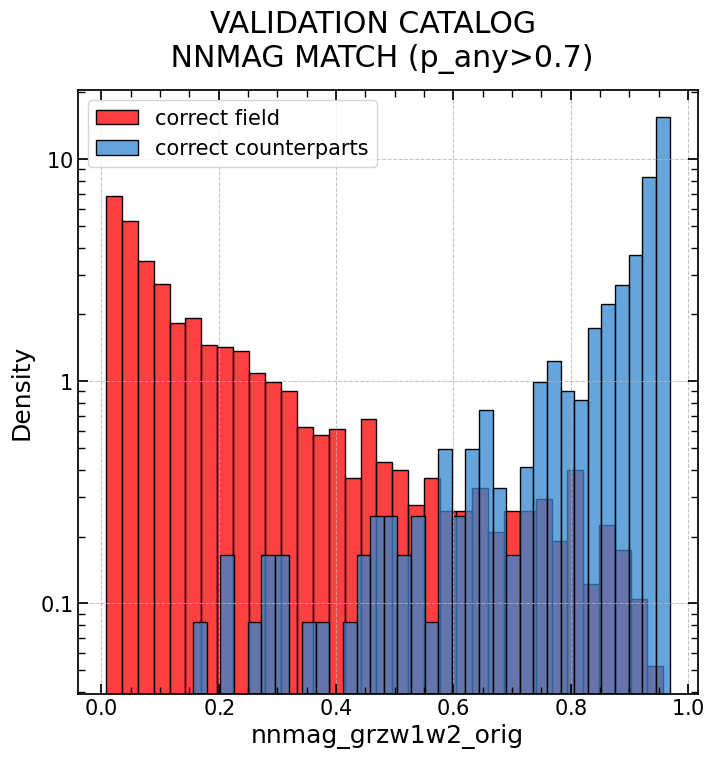

In [15]:
for prior_type in ['grz_orig', 'grzw1_orig', 'grzw1w2_orig']:
    prob_cutoff = 0.7
    plt.figure()
    sns.histplot(nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==0 & nnmag_{prior_type}!=-99. & ~desi_id_true_ctp.isnull()")['nnmag_'+prior_type], stat = 'density', color = 'r', bins = 35, label = 'correct field')
    sns.histplot(nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==1 & nnmag_{prior_type}!=-99. & desi_id==desi_id_true_ctp")['nnmag_'+prior_type], stat = 'density', bins = 35, label = 'correct counterparts')
    plt.suptitle(f'VALIDATION CATALOG \n NNMAG MATCH (p_any>{prob_cutoff})')
    plt.yscale('log')
    plt.legend()

# Offset between secure DESI matches and eROSITA sources

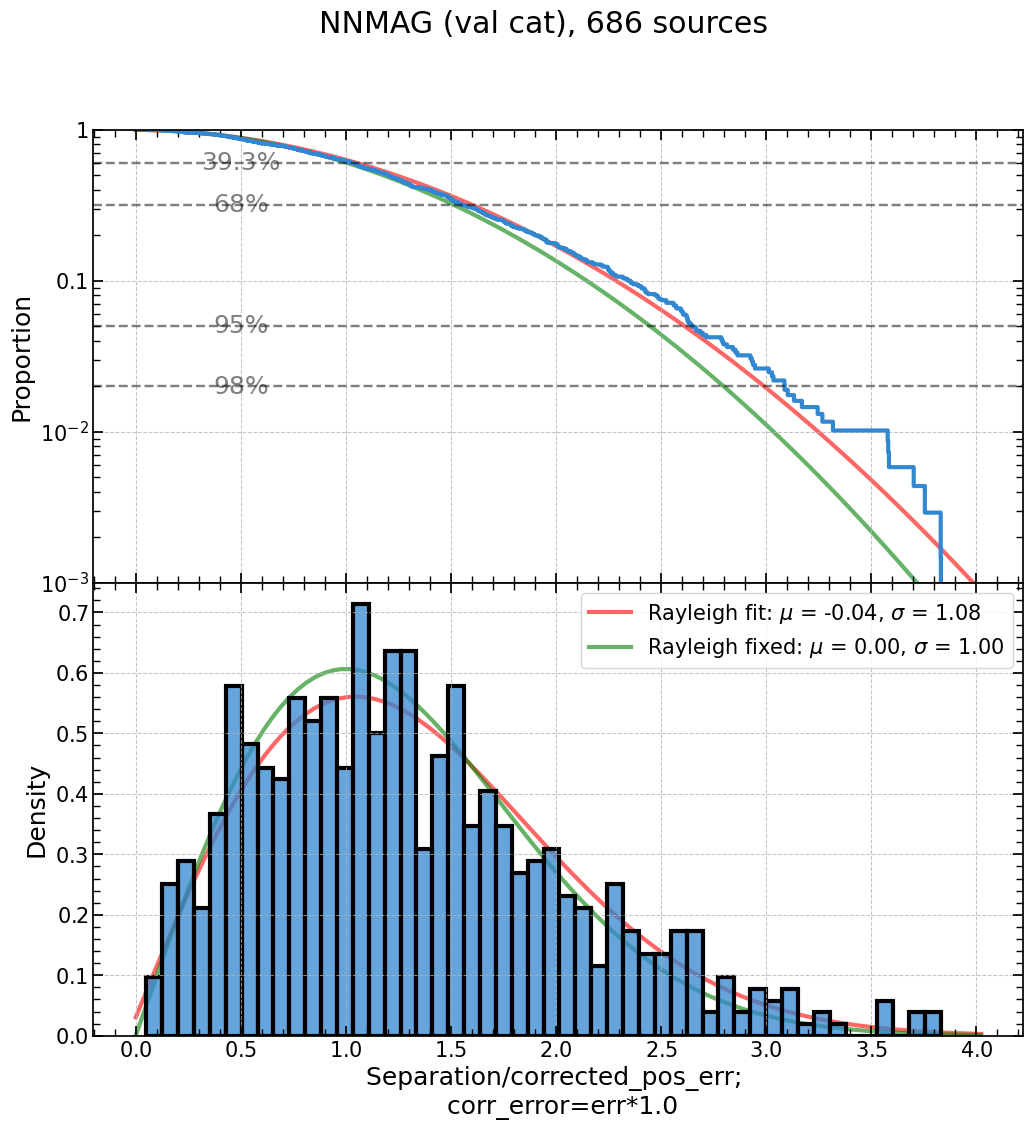

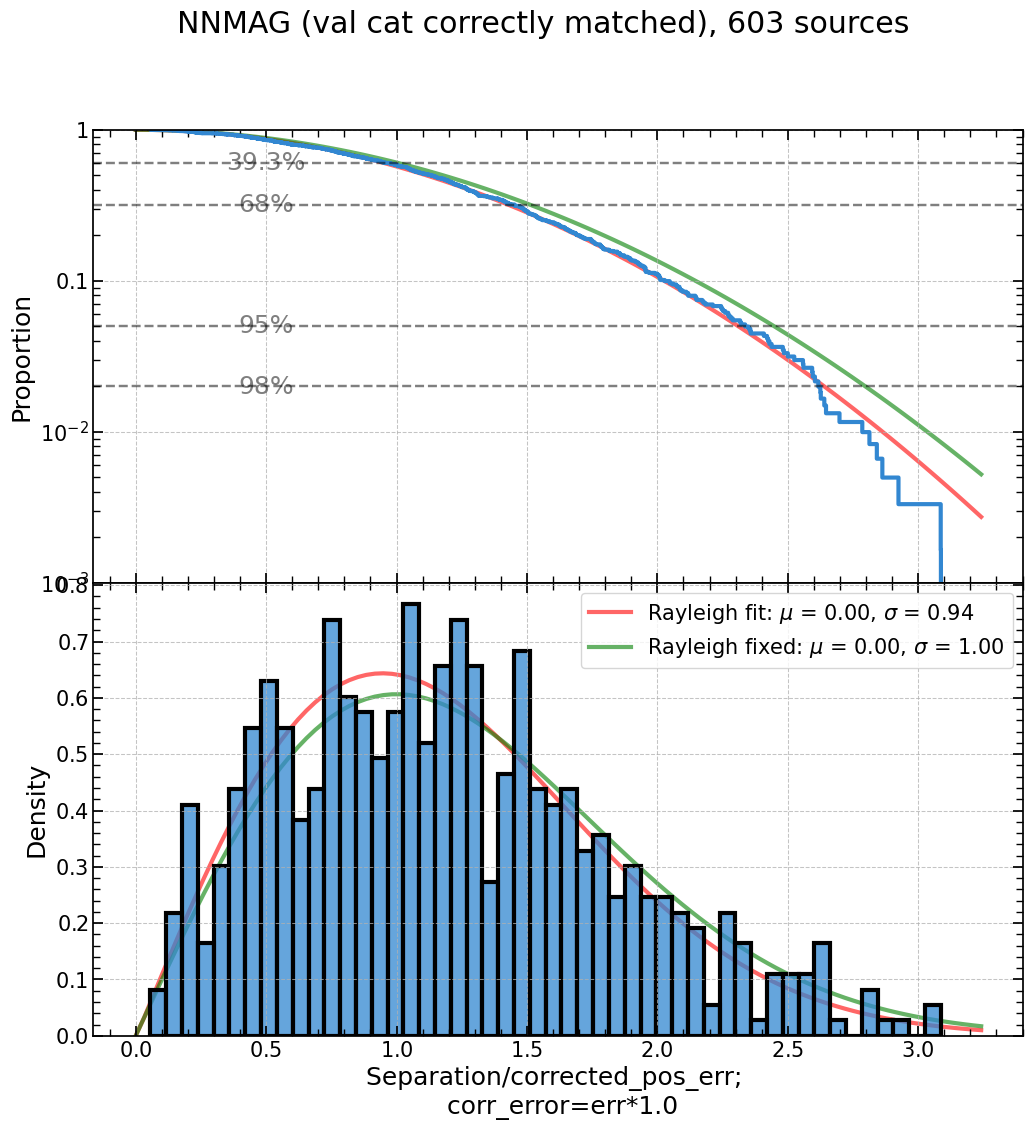

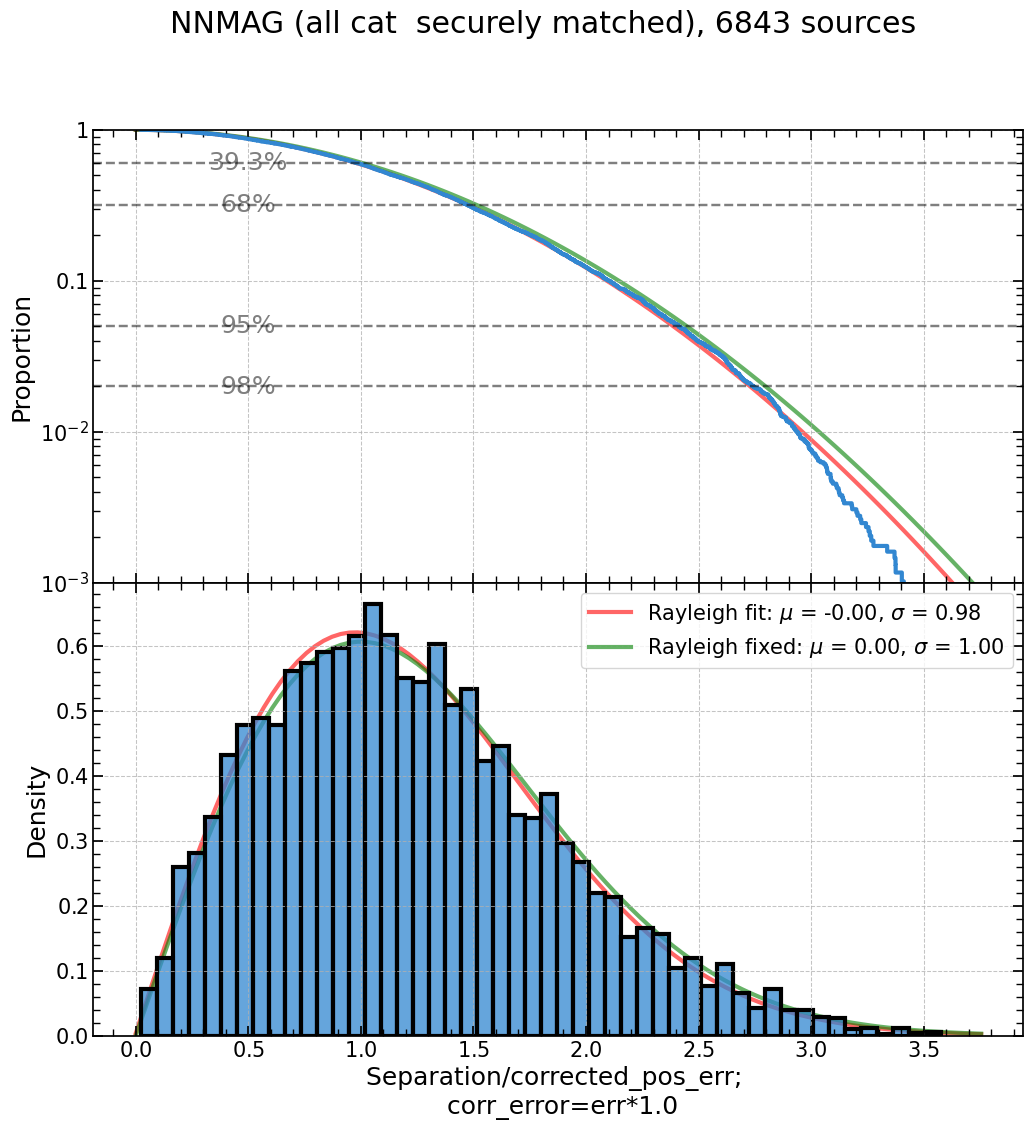

In [17]:

rayleigh_plot(nway_res.query('desi_id==desi_id_true_ctp & desi_id_true_ctp!="hostless"'), sep_col='Separation_EROSITA_DESI', pos_err_col = 'pos_err', plotlabel='NNMAG (val cat)')

rayleigh_plot(nway_res.query('match_flag==1 & desi_id==desi_id_true_ctp & desi_id_true_ctp!="hostless" & prob_has_match > 0.4'), sep_col='Separation_EROSITA_DESI', pos_err_col = 'pos_err', plotlabel='NNMAG (val cat correctly matched)')


rayleigh_plot(nway_res.query('match_flag==1  & desi_id_true_ctp!="hostless" & prob_has_match > 0.4'), sep_col='Separation_EROSITA_DESI', pos_err_col = 'pos_err', plotlabel='NNMAG (all cat  securely matched)')


# Catalog of best matches

`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.pkl` - catalog of the most-probable matches are saved in this catalog, i.e. one DESI object per eROSITA object.
`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates.gz_pkl` - all possible matches are saved in this catalog, i.e. a few DESI object per eROSITA object. The first file is found as a query `match_flag==1` on this catalog.
`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_dist_only.pkl` - the same as `ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.pkl`, but only astrometric information is used to determine the counterparts probabilities.


**Description**:

X-ray data:
* columns from `srcname_fin` to `NH` - original columns of Lockman Hole eROSITA catalog

Cross-match results:

* `nway_desi_id` - DESI candidate counterpart. `desi_id` is a concatenation of `release`, `brick` and `objid` of the DESI catalog.
* `nway_desi_id_true_ctp` - True DESI counterpart id if it is known from validation catalog. It is available for  approximately 600-700 sources eROSITA sources. Contains secure hostless sources. 
* `nway_Separation_EROSITA_DESI` - separation between `nway_desi_id` and eROSITA source
* `nway_pos_err` - positional error used by Nway, it is `factor*pos_sigma_2d` from the eROSITA catalog. Factor is `1` or close to `1`. In current version - `0.9`.  
* `nway_prob_has_match` - Nway probability of having a match in any of candidate counterparts. See calibration figures. Generally, if `nway_prob_has_match`>~0.8, the match is secure, and if `nway_prob_has_match`<~0.2, the match is not secure.
* `nway_prob_this_match` - assuming that eROSITA source has a match, this is the probability of this particular DESI source being a counterpart. 
* `nway_nnmag_grz(w1w2)` - Magnitude of Neural network photometric classifier. The largre the number, the more likely the source is a counterpart to a generic X-ray source.
* `nway_n_match_flag_0` - number of DESI sources inside 30 arcsec radius of the eROSITA source which have a low probability of being a counterpart: `nway_prob_this_match(secondary)`/`nway_prob_this_match(primary)<0.5`.
* `nway_n_match_flag_2` - the same but for high probability of being a counterpart: `nway_prob_this_match(secondary)`/`nway_prob_this_match(primary)>0.5`.
* `nway_is_closest` - True if the DESI candidate counterpart is the closest to the eROSITA source.
* `nway_is_within_pos_r98` - True if the DESI candidate counterpart is within the position error `pos_r98` of the eROSITA source.

Optical data:
* columns from `desi_release` onwards are the columns of the DESI catalog for a `nway_desi_id`.




Only reliable (SN>3) dereddened magnitudes  are used for the photometric probabilities, and SN>4 dereddened magnitudes are used for photometric model training excluding the Lockman Hole area.

In [37]:
save_cols = ['EROSITA', 'desi_id', 'desi_id_true_ctp',  'Separation_EROSITA_DESI',  'pos_err', 'prob_has_match', 'prob_this_match', 'nnmag_grzw1w2_orig', 'nnmag_grzw1_orig',    'nnmag_grz_orig', 'n_match_flag_0', 'n_match_flag_2', 'is_closest', 'is_within_pos_r98']


#TODO NWAY CLOSEST IS NOT PSF

rename_dict =  {
                                #'ID':'srcname_fin',
                                'Separation_EROSITA_DESI': 'nway_Separation_EROSITA_DESI',
                                'pos_err': 'nway_pos_err',
                                'prob_has_match': 'nway_prob_has_match',
                                'prob_this_match': 'nway_prob_this_match',
                                'nnmag_grzw1w2_orig': 'nway_nnmag_grzw1w2',
                                'nnmag_grzw1_orig': 'nway_nnmag_grzw1',
                                'nnmag_grz_orig': 'nway_nnmag_grz',
                                'desi_id': 'nway_desi_id',
                                'desi_id_true_ctp': 'nway_desi_id_true_ctp',
                                'n_match_flag_0': 'nway_n_match_flag_0',
                                'n_match_flag_2': 'nway_n_match_flag_2',
                                'is_closest': 'nway_is_closest',
                                'is_within_pos_r98': 'nway_is_within_pos_r98'
                                }


In [38]:

nway_match_res = nway_res.query('match_flag == 1 ')[save_cols].copy()

#add true desi id ctps
nway_match_res.rename(columns = rename_dict, inplace = True)


#nway_match_res.srcname_fin = nway_match_res.srcname_fin.str.decode('utf-8')
nway_match_res.nway_desi_id = nway_match_res.nway_desi_id.str.decode('utf-8')
nway_match_res.nway_desi_id_true_ctp = nway_match_res.nway_desi_id_true_ctp.str.decode('utf-8')

nway_match_res = erosita_orig_df.merge(nway_match_res, on = 'EROSITA')
nway_match_res = nway_match_res.merge(desi_pandas_ph, on = 'nway_desi_id')
nway_match_res.drop(columns = ['EROSITA'], inplace = True)
nway_match_res = nway_match_res.sort_values(['srcname_fin'])

nway_match_res.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.gz_pkl', compression='gzip')
nway_match_res

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_desi_id_true_ctp,nway_Separation_EROSITA_DESI,nway_pos_err,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_closest,nway_is_within_pos_r98,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min
1284,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_231,NaN,5.167984,2.982013,9.581405e-01,0.992349,0.949328,0.923767,0.845811,14,0,False,True,9011,231,606779,154.762154,56.504538,3.362170,4.618722,5.989522,16.031805,20.984790,50.180990,-3.493270,435.342250,248.158630,104.400180,3.761635,0.939089,0.001432,0.000018,21.087423,20.774010,20.520338,19.482046,19.191862,18.247932,NaN,70.151200,72.758970,61.198788,31.093582,20.335644,1.898610,-0.014626,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491
923,SRGe J101903.4+563325,154.764302,56.556994,154.897407,50.039645,12.232697,16.660557,2.758328e-14,6.850312e-15,34.209091,8.495835,1133.034668,0.0,0.0,0.0,4806,3902,154.766311,56.555705,5.407337,163.025894,0.000029,6.268413e+08,6.270701e+08,0.0,0.0,0.030192,0.007498,6.562579,154.764302,56.556994,-1,-1.000000,0,-1,NaN,-1.0,-1,SDSS J101904.67+563333.2,1.464000,QSO,13.943999,1,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,68265812198,5.407337,4.373272,6.601858,10.704663,132.318989,42.230639,2.122641e-14,1.507868e+20,9011_606779_284,NaN,12.929691,3.935945,2.397386e-01,0.843921,0.957462,0.923375,0.551305,9,0,False,False,9011,284,606779,154.769507,56.559155,4.110681,6.741001,7.775545,18.952187,29.332830,65.296720,371.384800,259.819270,99.752320,72.978060,3.654050,0.866400,0.001278,0.000015,20.872555,20.365770,20.238258,19.300547,18.828358,17.962076,16.075178,66.259700,67.326480,66.424300,36.228188,27.303180,2.334288,1.453649,PSF,-0.009351,1.285011,-0.184517,0.341205,-2.763030,0.601020,G2,853371518808768256,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491
1832,SRGe J101911.0+562639,154.795822,56.444182,155.033709,50.112976,7.855049,18.953989,1.654359e-14,3.709296e-15,40.391277,9.056271,2230.516357,0.0,0.0,0.0,4530,3655,154.797830,56.442893,3.409649,142.069946,0.000015,6.268413e+08,6.270701e+08,0.0,0.0,0.018108,0.004060,12.856621,154.795822,56.444182,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,

catalog of al all NWAY candidates

In [39]:
nway_match_res_all = nway_res[save_cols].copy()
nway_match_res_all.rename(columns = rename_dict, inplace = True)


#nway_match_res_all.srcname_fin = nway_match_res_all.srcname_fin.str.decode('utf-8')
nway_match_res_all.nway_desi_id = nway_match_res_all.nway_desi_id.str.decode('utf-8')
nway_match_res.nway_desi_id_true_ctp = nway_match_res.nway_desi_id_true_ctp.str.decode('utf-8')

nway_match_res_all = erosita_orig_df.merge(nway_match_res_all, on = 'EROSITA')
nway_match_res_all = nway_match_res_all.merge(desi_pandas_ph, on = 'nway_desi_id')
nway_match_res_all.drop(columns = ['EROSITA'], inplace = True)
nway_match_res_all = nway_match_res_all.sort_values(['srcname_fin'])

nway_match_res_all.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates.gz_pkl', compression='gzip')
nway_match_res_all

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_desi_id_true_ctp,nway_Separation_EROSITA_DESI,nway_pos_err,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_closest,nway_is_within_pos_r98,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min
20308,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_136,NaN,27.409272,2.982013,0.958140,3.150437e-20,-99.000000,-99.000000,0.307732,14,0,False,False,9011,136,606779,154.750219,56.506410,0.218289,0.259747,0.961538,0.669780,3.749257,-2.033533,86.168680,1064.01840,341.32450,68.936470,4.096830,1.032611,0.001391,0.000018,24.056936,23.899303,22.506605,22.929703,21.061779,NaN,17.661356,7.120420,4.798818,7.983458,1.355677,3.809900,-0.075839,0.361240,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491
20298,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_270,NaN,8.700815,2.982013,0.958140,5.186943e-05,-99.000000,-99.000000,-99.000000,14,0,False,False,9011,270,606779,154.767902,56.504561,0.006182,0.248752,0.683425,1.459805,1.837475,66.774700,1655.514600,655.65480,227.15985,115.640930,4.061457,1.005804,0.001428,0.000018,27.925978,23.945800,22.877037,22.083757,21.836065,17.937750,14.452395,0.158299,3.749141,7.349307,2.941953,1.842799,2.523207,6.929879,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491
20299,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92

In [40]:
nway_match_res_dist_only = nway_res_dist_only.query('match_flag == 1 ')[save_cols].copy()


nway_match_res_dist_only.rename(columns = rename_dict, inplace = True)


#nway_match_res_dist_only.srcname_fin = nway_match_res_dist_only.srcname_fin.str.decode('utf-8')
nway_match_res_dist_only.nway_desi_id = nway_match_res_dist_only.nway_desi_id.str.decode('utf-8')
nway_match_res_dist_only.nway_desi_id_true_ctp = nway_match_res_dist_only.nway_desi_id_true_ctp.str.decode('utf-8')

nway_match_res_dist_only = erosita_orig_df.merge(nway_match_res_dist_only, on = 'EROSITA')
nway_match_res_dist_only = nway_match_res_dist_only.merge(desi_pandas_ph, on = 'nway_desi_id')
nway_match_res_dist_only.drop(columns = ['EROSITA'], inplace = True)
nway_match_res_dist_only = nway_match_res_dist_only.sort_values(['srcname_fin'])

nway_match_res_dist_only.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_dist_only.gz_pkl', compression='gzip')
nway_match_res_dist_only

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_desi_id_true_ctp,nway_Separation_EROSITA_DESI,nway_pos_err,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_closest,nway_is_within_pos_r98,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min
1284,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_239,NaN,4.917724,2.982013,7.065773e-01,0.426806,-99.000000,0.018541,0.421334,13,1,True,True,9011,239,606779,154.763287,56.506903,0.321437,1.060153,4.870105,2.290698,1.339155,55.415050,413.594060,631.809270,211.408690,105.205840,4.324362,1.051834,0.001422,0.000018,23.636383,22.371996,20.745030,21.594591,22.179552,18.140211,15.958293,8.079594,15.414515,49.952614,4.763529,1.373424,2.090021,1.732247,PSF,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491
923,SRGe J101903.4+563325,154.764302,56.556994,154.897407,50.039645,12.232697,16.660557,2.758328e-14,6.850312e-15,34.209091,8.495835,1133.034668,0.0,0.0,0.0,4806,3902,154.766311,56.555705,5.407337,163.025894,0.000029,6.268413e+08,6.270701e+08,0.0,0.0,0.030192,0.007498,6.562579,154.764302,56.556994,-1,-1.000000,0,-1,NaN,-1.0,-1,SDSS J101904.67+563333.2,1.464000,QSO,13.943999,1,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,68265812198,5.407337,4.373272,6.601858,10.704663,132.318989,42.230639,2.122641e-14,1.507868e+20,9011_606779_218,NaN,9.594825,3.935945,1.763442e-01,0.550453,-99.000000,-99.000000,0.195660,9,0,True,True,9011,218,606779,154.760218,56.555567,0.269704,0.338683,0.553034,-0.120784,0.548857,-18.639507,529.034200,412.783360,279.548680,79.561584,4.304590,1.023274,0.001280,0.000016,23.830263,23.613194,23.108260,NaN,23.148098,NaN,15.691029,5.479592,5.662688,4.932916,-0.250596,0.555208,-0.666961,2.135560,PSF,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.388402,57784.424786,2018-03-17 09:19:17.912,2017-01-31 10:11:41.491
1832,SRGe J101911.0+562639,154.795822,56.444182,155.033709,50.112976,7.855049,18.953989,1.654359e-14,3.709296e-15,40.391277,9.056271,2230.516357,0.0,0.0,0.0,4530,3655,154.797830,56.442893,3.409649,142.069946,0.000015,6.268413e+08,6.270701e+08,0.0,0.0,0.018108,0.004060,12.856621,154.795822,56.444182,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0

# Example of a Quasar

desi_id = '9011_606780_1256' is a most probable counterpart of the eROSITA source. 

see image [link](https://www.legacysurvey.org/viewer/?ra=155.3501&dec=56.5357&layer=ls-dr9&zoom=16&spectra)

In [41]:
#nway_match_res.query('nway_desi_id == "9011_606780_1256"')
#nway_match_res.query('srcname_fin == "SRGe J102122.9+563214"').sort_values(['nway_prob_this_match'])
nway_match_res_all.query('srcname_fin == "SRGe J102122.9+563214"').sort_values(by = 'nway_prob_this_match', ascending = False).head(5)[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_r98', 'flux_05-20', 'nway_desi_id', 'nway_Separation_EROSITA_DESI', 'nway_prob_has_match', 'nway_nnmag_grzw1w2',	'nway_nnmag_grzw1',	'nway_nnmag_grz', 'desi_dered_mag_g', 'desi_dered_mag_r', 'desi_dered_mag_z']]

,srcname_fin,RA_fin,DEC_fin,pos_r98,flux_05-20,nway_desi_id,nway_Separation_EROSITA_DESI,nway_prob_has_match,nway_nnmag_grzw1w2,nway_nnmag_grzw1,nway_nnmag_grz,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z
133922,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1256,16.592597,0.382879,0.966172,0.930407,0.658961,20.402922,19.976002,19.667910
133923,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1202,1.525698,0.382879,-99.000000,-99.000000,0.119184,23.891247,23.696724,23.387978
133924,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1207,6.372686,0.382879,-99.000000,-99.000000,-99.000000,24.981260,23.745020,23.064909
133925,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1229,13.083675,0.382879,-99.000000,-99.000000,0.103030,23.614704,22.644236,22.132998
133926,SRGe J102122.9+563214,155.345344,56.53735,16.901592,2.226497e-15,9011_606780_1234,14.940570,0.382879,-99.000000,-99.000000,0.077030,23.926240,23.053194,22.599337



![](../0_data/qso_example.png)


NWAY results for Source 9075:

It is uncertain if this source has a counterpart (p_any=0.38)

Assuming it has a counterpart, we have the following possible associations:

visible_rad=40.000000
Disclaimer: These results assume that the input (sky densities, positional errors, and priors) are correct.



,Separation_EROSITA_DESI,pos_err,match_flag,prob_has_match,prob_this_match,ID,desi_id_true_ctp,desi_id,prior_type,nnmag_grzw1w2,nnmag_grzw1,nnmag_grz
133922,16.592597,5.43819,1,0.382879,0.669097,b'SRGe J102122.9+563214',NaN,b'9011_606780_1256',b'grzw1w2',0.966172,-99.0,-99.000000
133929,1.525698,5.43819,0,0.382879,0.271667,b'SRGe J102122.9+563214',NaN,b'9011_606780_1202',b'grz',-99.000000,-99.0,0.119184
133933,6.372686,5.43819,0,0.382879,0.033727,b'SRGe J102122.9+563214',NaN,b'9011_606780_1207',b'None',-99.000000,-99.0,-99.000000


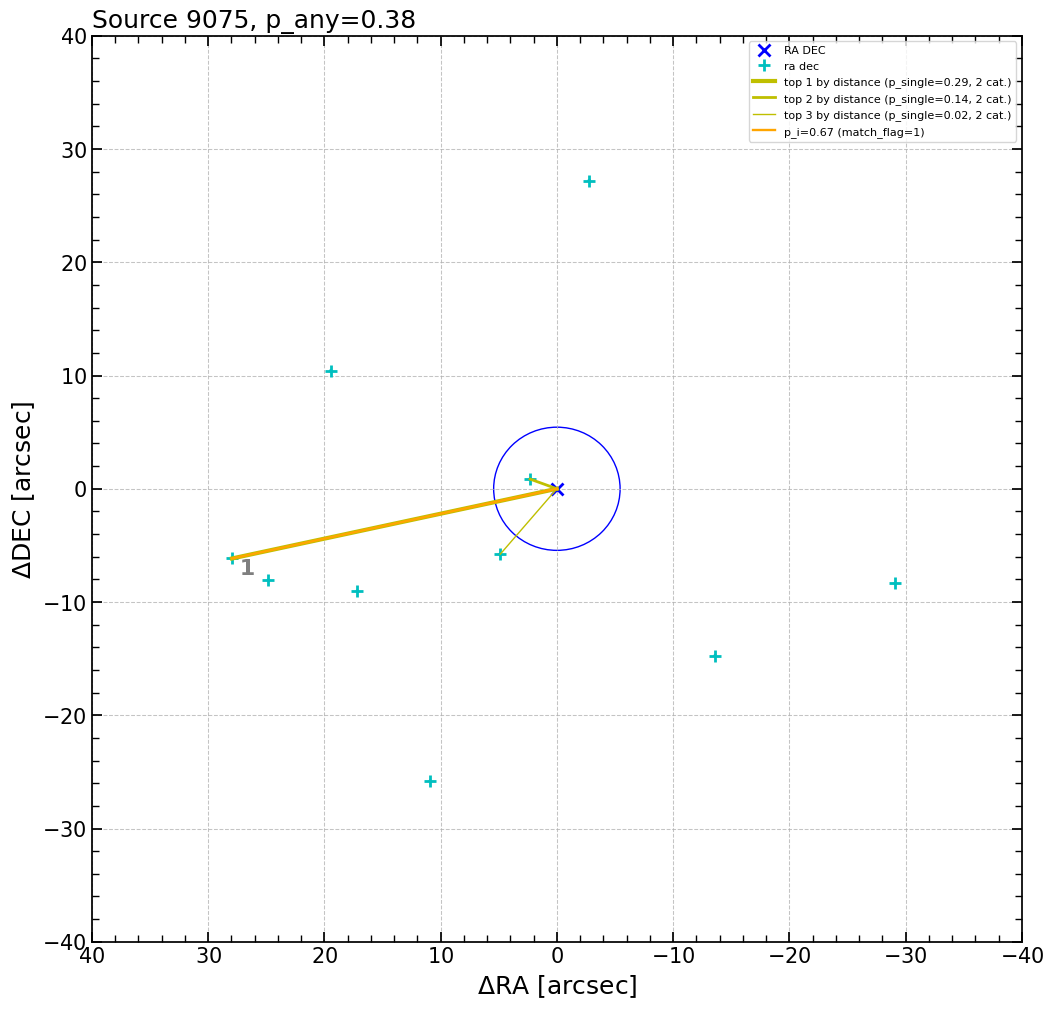

In [42]:
import nway_python_api as nway
test_columns_explain = ['Separation_EROSITA_DESI', 'pos_err',
       'match_flag', 'prob_has_match', 'prob_this_match',
       'ID', 'desi_id_true_ctp', 'desi_id', 'prior_type',
       'nnmag_grzw1w2', 'nnmag_grzw1', 'nnmag_grz', ]
explain_args = {'primary_id_col':'EROSITA', 'cols_ra' : ['RA', 'ra'], 'cols_dec':['DEC', 'dec'], 'cols_err': ['pos_err', 'desi_pos_err'], 'tablenames': ['EROSITA', 'DESI']}
ero_id = nway_res.query("ID == b'SRGe J102122.9+563214'").sort_values(by = 'prob_this_match', ascending = False)['EROSITA'].iloc[0]
nway.explain(nway_res, id = ero_id, visible_rad = 40, **explain_args)[test_columns_explain].head(3)


In [43]:
nway_match_res_all.query('nway_desi_id == "9011_606780_1256"')[['desi_ra', 'desi_dec', 'desi_release',	'desi_objid',	'desi_brickid']]

,desi_ra,desi_dec,desi_release,desi_objid,desi_brickid
133922,155.353106,56.53564,9011,1256,606780
